**KAGGLE COMPETITION : DEEP LEARNING APPROACH**

**A. Preprocessing**
1. Import libraries
2. Import dataset
3. Basic data cleaning : get rid of null values, punctuation and html tags
4. NLP data preprocessing : remove stop words, stem/lemmatize words
5. Word embeddings
<!-- 5. Test-Train split
6. Vecorize data (fit on the train data and use on train+test data) with countvec or tfidfvec
7. Oversample data (deal with imbalanced data with SMOTE) -->

**B. Models**

Implement DL models (RNN,LSTM,BERT...)

**C. Make prediction** 

Submit predictions and put my name on the leaderboard !!

In [11]:
import pandas as pd
import numpy as np
import regex as re
import os
import pickle
import scipy
import nltk
from imblearn.over_sampling import SMOTE
from nltk.stem.porter import PorterStemmer
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\adrie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
import pandas as pd
import numpy as np
import regex as re
import os
import nltk
from imblearn.over_sampling import SMOTE
from nltk.stem.porter import PorterStemmer
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS

def clean_reviews(review):
    #find and replace all punctuation with "" and all html tags with " " + lower
    print("   ")
    REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
    REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")
    review = REPLACE_NO_SPACE.sub("", review.lower()) 
    review = REPLACE_WITH_SPACE.sub(" ", review)
    return review

def remove_repeating_words(review):
    #review1 = ' '.join(set(review.split()))
    review = ' '.join(dict.fromkeys(review.split()))
    return review

def remove_stop_words(review):
    stop_words_list = ENGLISH_STOP_WORDS #stop_words.
    review = " ".join(word for word in review.split(" ") if word not in stop_words_list)
    return review

def stem_reviews(review):
    # PB : NEED TO INITIATE A NEW STEMMER FOR EACH ROW...
    stemmer = PorterStemmer()
    #separator.join(list of strings) => 1 long string
    #string.split(separator) => list of strings
    review = " ".join([stemmer.stem(word) for word in review.split(" ")])
    return review

def lemmatize_reviews(review):
    lemmatizer = WordNetLemmatizer()
    #separator.join(list of strings) => 1 long string
    #string.split(separator) => list of strings
    review = " ".join([lemmatizer.lemmatize(word) for word in review.split(" ")])
    return review

def oversample(data_list):
    [X_train, y_train, X_eval, y_eval] = data_list
    sm = SMOTE()
    X_train_sm, y_train_sm = sm.fit_resample(X_train,y_train)
    X_eval_sm, y_eval_sm = sm.fit_resample(X_eval,y_eval)
    assert len(y_train_sm.value_counts().unique())==1 and len(y_eval_sm.value_counts().unique())==1
    return [X_train_sm, y_train_sm,X_eval_sm, y_eval_sm]


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\adrie\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [13]:
def read_input_data(filename, separator, use_cols, header, col_dict):
    print("Reading input data")
    df = pd.read_csv(filename, sep = separator, usecols = use_cols, header = header)
    df.rename(columns = col_dict, inplace = True)
    print(df.shape)
    print(df.head())
    return df

def basic_clean(df) -> None:
    print("Basic Data Preprocessing : \n Dropping null values \n Getting rid of punctuation and HTML tags + text in lowercase \n Removing repeating words")
    df.dropna(inplace = True)
    df["Reviews"] = df["Reviews"].apply(lambda row : remove_repeating_words(clean_reviews(row)))


def nlp_clean(df, nlp_method) -> None:
    print("NLP Data Preprocessing : Removing stop words \n Stemming/Lemmatizing reviews")
    if nlp_method == "stem":
        df["Reviews"] = df["Reviews"].apply(lambda row : stem_reviews(remove_stop_words(row)))
    elif nlp_method == "lemmatize":
        df["Reviews"] = df["Reviews"].apply(lambda row : lemmatize_reviews(remove_stop_words(row)))
    else:
        df["Reviews"] = df["Reviews"].apply(lambda row : remove_stop_words(row))

def data_split(X, y, test_size = 0.2, random_state = 42) -> None:
    y_ohe = pd.get_dummies(y)
    print(y_ohe)
    data_list = train_test_split(X,y_ohe,test_size=test_size,random_state=random_state)
    return data_list

In [14]:
# print("**************** PREPROCESSING TRAIN DATA ****************")
# train_vec, train_data_list = data_preprocessor_train("train.tsv", '\t', 0, [2, 3], {"Phrase":"Reviews","Sentiment":"Sentiments"})
# print("**************** PREPROCESSING TEST DATA ****************")
# test_vec, test_data = data_processor_test("test.tsv", '\t', 0, [0, 2], [0],{"Phrase":"Reviews"}, train_vec) #NO NEED FOR THE PHRASEID COLUMN (INDEX IS NOT NECESSARY)

df = read_input_data("train.tsv", '\t', [2,3],0,{"Phrase":"Reviews","Sentiment":"Sentiments"})
basic_clean(df)
nlp_clean(df,"lemmatize")
print(df.head())

Reading input data
(156060, 2)
                                             Reviews  Sentiments
0  A series of escapades demonstrating the adage ...           1
1  A series of escapades demonstrating the adage ...           2
2                                           A series           2
3                                                  A           2
4                                             series           2
Basic Data Preprocessing : 
 Dropping null values 
 Getting rid of punctuation and HTML tags + text in lowercase 
 Removing repeating words
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   

In [15]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import regularizers

MAX_WORDS = 2500
MAX_LEN = 200

def tokenize_data(df, tk = None, max_words = MAX_WORDS, max_len = MAX_LEN):
    data = df['Reviews'].values.tolist()
    print(data[:10])
    if tk == None:
        tokenizer = Tokenizer(num_words=max_words)
        tokenizer.fit_on_texts(data)
    else:
        tokenizer = tk
    sequences_init = tokenizer.texts_to_sequences(data)
    sequences = pad_sequences(sequences_init, maxlen=max_len)
    print(f"Size of input tokenized data :\n(Nb of samples, sequence length) = {sequences.shape}")
    # print(sequences)
    return sequences, tokenizer



In [16]:
sequences, tokenizer = tokenize_data(df)
data_list = data_split(sequences, df["Sentiments"])
data_list


['series escapade demonstrating adage good goose gander occasionally amuses amount story', 'series escapade demonstrating adage good goose', 'series', '', 'series', 'escapade demonstrating adage good goose', '', 'escapade demonstrating adage good goose', 'escapade', 'demonstrating adage good goose']
Size of input tokenized data :
(Nb of samples, sequence length) = (156060, 200)
[[   0    0    0 ...  479 1871    7]
 [   0    0    0 ...    0  189   11]
 [   0    0    0 ...    0    0  189]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]]
        0  1  2  3  4
0       0  1  0  0  0
1       0  0  1  0  0
2       0  0  1  0  0
3       0  0  1  0  0
4       0  0  1  0  0
...    .. .. .. .. ..
156055  0  0  1  0  0
156056  0  1  0  0  0
156057  0  0  0  1  0
156058  0  0  1  0  0
156059  0  0  1  0  0

[156060 rows x 5 columns]


[array([[   0,    0,    0, ...,    0,    0, 1387],
        [   0,    0,    0, ...,    0, 1920,   10],
        [   0,    0,    0, ...,    1,  544,  477],
        ...,
        [   0,    0,    0, ..., 1981,  656,   98],
        [   0,    0,    0, ...,  884,  213, 1223],
        [   0,    0,    0, ...,  571,   30, 1730]]),
 array([[   0,    0,    0, ...,    0,    0,    1],
        [   0,    0,    0, ...,  487,  111, 1896],
        [   0,    0,    0, ...,    0,    0,   82],
        ...,
        [   0,    0,    0, ...,    0,  462,  133],
        [   0,    0,    0, ...,    0, 1743,  238],
        [   0,    0,    0, ...,    0,    0,  312]]),
         0  1  2  3  4
 22538   0  1  0  0  0
 99237   0  0  1  0  0
 60377   1  0  0  0  0
 128317  0  0  1  0  0
 20776   0  1  0  0  0
 ...    .. .. .. .. ..
 119879  0  0  1  0  0
 103694  0  0  1  0  0
 131932  0  0  0  1  0
 146867  0  0  0  1  0
 121958  0  0  1  0  0
 
 [124848 rows x 5 columns],
         0  1  2  3  4
 95722   0  0  1  0  0
 14731

In [17]:
from keras.models import Sequential
from keras import layers
from keras import regularizers
from keras import backend as K
from keras.callbacks import ModelCheckpoint

def simple_model(data_list, type):
    X_train, X_test, y_train, y_test = data_list
    model1 = Sequential()
    model1.add(layers.Embedding(MAX_WORDS, 20, input_length=MAX_LEN)) #The embedding layer
    if type == "lstm":
        model1.add(layers.LSTM(15,dropout=0.5)) #Our LSTM layer with dropout (regularization)
    else:
    # Possibility to add multiple RNN layers instead of a single LSTM layer
    # NEED TO RETURN ALL SEQUENCES !!!
        model1.add(layers.SimpleRNN(15, return_sequences=True))
        model1.add(layers.SimpleRNN(15, dropout=0.5))
    model1.add(layers.Dense(5,activation='softmax')) #Activation function for multiclass classifiation
    # OUTPUT VECTORS MUST BE ONE HOT ENCODED !!!!!!!!!!!!!
    print(model1.summary())

    model1.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy']) #other optimizer : adam, adadelta


    checkpoint1 = ModelCheckpoint("best_model1.hdf5", monitor='val_accuracy', verbose=5,save_best_only=True, mode='auto', period=1,save_weights_only=False)
    history = model1.fit(X_train, y_train, epochs=50,batch_size=512,validation_data=(X_test, y_test),callbacks=[checkpoint1])
    return history

def bid_model(data_list):
    X_train, X_test, y_train, y_test = data_list
    model2 = Sequential()
    model2.add(layers.Embedding(MAX_WORDS, 40, input_length=MAX_LEN))
    model2.add(layers.Bidirectional(layers.LSTM(128,dropout=0.2))) #0.2
    model2.add(layers.Dense(64, activation = 'relu'))
    model2.add(layers.Dropout(0.5))
    model2.add(layers.Dense(5,activation='softmax'))
    print(model2.summary())
    model2.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy']) #rmsprop
    checkpoint2 = ModelCheckpoint("best_model2.hdf5", monitor='val_accuracy', verbose=5,save_best_only=True, mode='auto', period=1,save_weights_only=False)
    history = model2.fit(X_train, y_train, epochs=30,batch_size=512, validation_data=(X_test, y_test),callbacks=[checkpoint2])
    return history

def conv1D_model(data_list):
    X_train, X_test, y_train, y_test = data_list
    model3 = Sequential()
    model3.add(layers.Embedding(MAX_WORDS, 40, input_length=MAX_LEN))
    model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
    model3.add(layers.MaxPooling1D(5))
    model3.add(layers.Conv1D(20, 6, activation='relu',kernel_regularizer=regularizers.l1_l2(l1=2e-3, l2=2e-3),bias_regularizer=regularizers.l2(2e-3)))
    model3.add(layers.GlobalMaxPooling1D())
    model3.add(layers.Dense(5,activation='softmax'))
    print(model3.summary())
    model3.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy']) #acc
    checkpoint3 = ModelCheckpoint("best_model3.hdf5", monitor='val_accuracy', verbose=5,save_best_only=True, mode='auto', period=1,save_weights_only=False)
    history = model3.fit(X_train, y_train, epochs=20,validation_data=(X_test, y_test), callbacks=[checkpoint3])
    return history


In [18]:
from time import time
t0 = time()
# history = simple_model(data_list, "rnn")
history = bid_model(data_list)
# history = conv1D_model(data_list)
train_time = time() - t0
print(train_time)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 40)           100000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               173056    
_________________________________________________________________
dense_3 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 5)                 325       
Total params: 289,829
Trainable params: 289,829
Non-trainable params: 0
_________________________________________________________________
None


C:\Users\adrie\anaconda3\envs\sentiment\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 124848 samples, validate on 31212 samples
Epoch 1/30
124848/124848 [==============================] - 874s 7ms/step - loss: 1.2069 - accuracy: 0.5361 - val_loss: 1.1140 - val_accuracy: 0.5596

Epoch 00001: val_accuracy improved from -inf to 0.55962, saving model to best_model2.hdf5
Epoch 2/30
124848/124848 [==============================] - 928s 7ms/step - loss: 1.0544 - accuracy: 0.5952 - val_loss: 1.0019 - val_accuracy: 0.6038

Epoch 00002: val_accuracy improved from 0.55962 to 0.60377, saving model to best_model2.hdf5
Epoch 3/30
124848/124848 [==============================] - 901s 7ms/step - loss: 1.0029 - accuracy: 0.6102 - val_loss: 0.9879 - val_accuracy: 0.6103

Epoch 00003: val_accuracy improved from 0.60377 to 0.61031, saving model to best_model2.hdf5
Epoch 4/30
124848/124848 [==============================] - 927s 7ms/step - loss: 0.9889 - accuracy: 0.6153 - val_loss: 0.9843 - val_accuracy: 0.6140

Epoch 00004: val_accuracy improved from 0.61031 to 0.61399, saving mo

<Figure size 432x288 with 0 Axes>

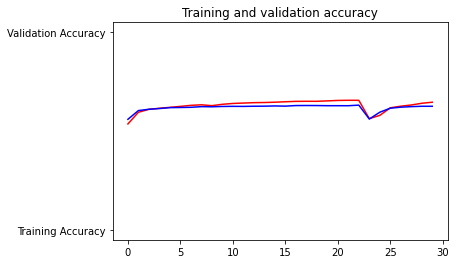

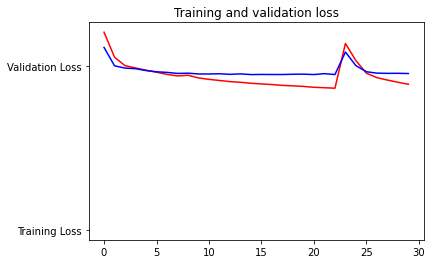

<Figure size 432x288 with 0 Axes>

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs=range(len(acc))
plt.plot(epochs, acc, 'r', 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', 'Validation Accuracy')
plt.title('Training and validation accuracy')
plt.figure()
plt.plot(epochs, loss, 'r', 'Training Loss')
plt.plot(epochs, val_loss, 'b', 'Validation Loss')
plt.title('Training and validation loss')
plt.figure()

In [20]:
from keras import models

df_test = read_input_data("test.tsv", '\t', [2],0,{"Phrase":"Reviews"})
basic_clean(df_test)
nlp_clean(df_test,"lemmatize")
X_pred, _ = tokenize_data(df_test, tk = tokenizer)
print(X_pred)
final_model = models.load_model('best_model2.hdf5')
final_pred = final_model.predict_classes(X_pred)
# index = pd.read_csv("test.tsv", sep = '\t').index
submission = pd.DataFrame({"PhraseId":[i for i in range(156061,222353)],"Sentiment":final_pred})
submission.to_csv(f"Submission.csv", index=False)

Reading input data
(66292, 1)
                                             Reviews
0  An intermittently pleasing but mostly routine ...
1  An intermittently pleasing but mostly routine ...
2                                                 An
3  intermittently pleasing but mostly routine effort
4         intermittently pleasing but mostly routine
Basic Data Preprocessing : 
 Dropping null values 
 Getting rid of punctuation and HTML tags + text in lowercase 
 Removing repeating words
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   
   


C:\Users\adrie\anaconda3\envs\sentiment\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
